---
**License**

 CLMM_backend_comp

 Sat Jan 09 16:11:00 2021\
 Copyright  2021\
 Mariana Penna-Lima <pennalima@gmail.com>

---
---

 CLMM_backend_comp\
 Copyright (C) 2021 Mariana Penna-Lima <pennalima@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
# NumCosmo
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

# Colossus
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import mass_so
from colossus.utils import constants

# CCL
import pyccl as ccl

# Cluster-toolkit
from astropy.cosmology import FlatLambdaCDM
import cluster_toolkit as ct

import sys
import numpy as np
import math
import matplotlib.pyplot as plt


In [2]:
# Colossus Cosmology
cosmo_col = cosmology.setCosmology('planck18');

Omega_c_col = cosmo_col.Om0 - cosmo_col.Ob0
Omega_b_col = cosmo_col.Ob0
h_col       = cosmo_col.H0 / 100.0
n_s_col     = cosmo_col.ns

# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c_col, Omega_b=Omega_b_col, h=h_col, A_s=2.1e-9, n_s=n_s_col)

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# CT cosmology
cosmo = FlatLambdaCDM(H0=cosmo_col.H0, Om0=cosmo_col.Om0, Ob0=cosmo_col.Ob0)

In [3]:
# NumCosmo Cosmology
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w",         cosmo_col.w0)
#cosmo.param_set_by_name ("w1",        cosmo_col.wa)
cosmo.param_set_by_name ("Omegab",    Omega_b_col)
cosmo.param_set_by_name ("Omegac",    Omega_c_col)
#cosmo.param_set_by_name ("massnu_0",  Planck13.m_nu.value[2])
#cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff - 3.0 * cosmo.E2Press_mnu (1.0e10) / (cosmo.E2Omega_g (1.0e10) * (7 / 8 * (4 / 11)**(4 / 3))))
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff)
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)


In [4]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))

In [5]:
Delta = 200.0
Delta_ccl = 200.0#'vir'
Mvir  = 1.0e15 # M_sun
cvir  = 5.0
z     = 0.2
a     = 1.0 / (1.0 + z)

# CCL
MDEF               = 'matter'
mdef               = ccl.halos.MassDef (Delta_ccl, MDEF)
conc               = ccl.halos.ConcentrationConstant(cvir)
mdef.concentration = conc
ccl_nfw            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = True, 
                                               cumul2d_analytic = True)

# Colossus
col_nfw = profile_nfw.NFWProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = '200m')

In [7]:
# NumCosmo
reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.MEAN, Delta) 
nc_nfw.param_set_by_name ('cDelta', cvir) 
nc_nfw.param_set_by_name ('log10MDelta', math.log10(Mvir)) 

if improve_prec:
    nc_nfw.set_reltol (reltol) 
    nc_nfw.set_lnXi (lnXi)
    nc_nfw.set_lnXf (lnXf)

smd = Nc.WLSurfaceMassDensity.new (Nc.Distance.new (5.0))
smd.prepare (cosmo)

**Comparing NFW, Einasto and Hernquist the scale radius $r_s$ and $\rho_s$**

In [9]:
r     = 10**np.arange (-1, +4, 0.02) * 1.0e-3 # Mpc - physical
rho_m = cosmo_col.rho_m (z) * (cosmo.h2 () * 1.0e9) # matter density units: M_sun / Mpc^3

# Colossus 
(col_rhos, col_rs)  = col_nfw.fundamentalParameters (Mvir * cosmo.h (), cvir, z, '200m')

# CCL scale radius NFW
R_M = mdef.get_radius(cosmo_ccl, Mvir, a) / a 
c = conc.get_concentration(cosmo_ccl, Mvir, a, mdef_other=mdef)
ccl_rs = R_M / c
ccl_rhos = ccl_nfw._norm (Mvir, ccl_rs, c)

# NumCosmo
(nc_rs, nc_rhos)    = nc_nfw.r_s_rho_s (cosmo, z)

cmp_double ("NFW:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_rhos)
cmp_double ("NFW:rs  ", "Colossus", "NumCosmo", col_rs / 1.0e3 / cosmo.h (), nc_rs)
cmp_double ("NFW:rhos", "CCL     ", "NumCosmo", ccl_rhos / a**3, nc_rhos)
cmp_double ("NFW:rs  ", "CCL     ", "NumCosmo", a * ccl_rs, nc_rs)


NFW:rhos: Colossus =        593865571078916, NumCosmo =        593865571079178, CMP:  4.42e-13
NFW:rs  : Colossus =      0.519016438491629, NumCosmo =      0.519016438491552, CMP:  1.48e-13
NFW:rhos: CCL      =        593865571079690, NumCosmo =        593865571079178, CMP:  8.62e-13
NFW:rs  : CCL      =      0.519016438491403, NumCosmo =      0.519016438491552, CMP:  2.87e-13


**Comparing NFW, Einasto and Hernquist profiles $\rho(r) /\rho_m$**

NameError: name 'ct_rho_nfw' is not defined

<Figure size 432x288 with 0 Axes>

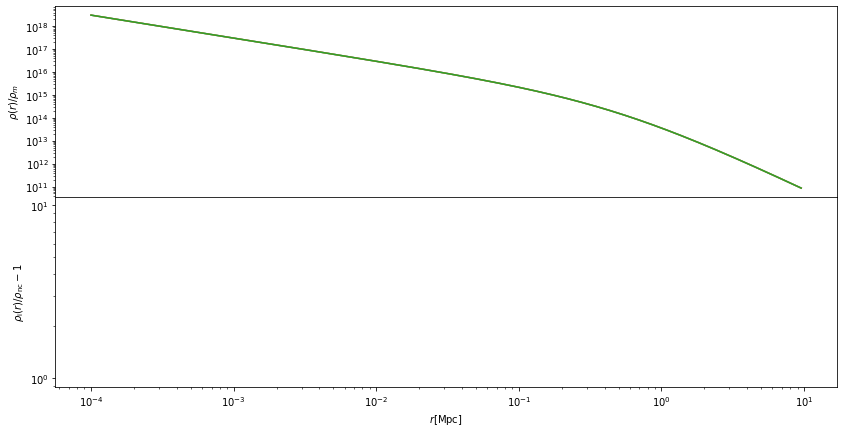

In [11]:
# Colossus density profiles
col_rho_nfw = col_nfw.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

# NumCosmo density profiles
nc_rho_nfw  = np.array (nc_nfw.eval_density_array (cosmo, r, 1.0, 1.0, z))

# CCL density profiles
# CCL input: comoving distance 
ccl_rho_nfw = ccl_nfw.real (cosmo_ccl, r / a, Mvir, a, mdef) / a**3

# CT density profile

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$r$[Mpc]')
axs[0].set_ylabel(r'$\rho (r) / \rho_m$')
axs[1].set_ylabel(r'$\rho_{\mathrm{i}} (r) / \rho_{\mathrm{nc}} - 1$')
axs[0].plot (r, col_rho_nfw, '-', label = 'NFW - Col')
axs[0].plot (r, nc_rho_nfw,  '-', label = 'NFW - NC')
axs[0].plot (r, ccl_rho_nfw, '-', label = 'NFW - CCL')
axs[0].plot (r, ct_rho_nfw,  '-', label = 'NFW - CT')

axs[1].plot (r, np.abs (col_rho_nfw / nc_rho_nfw  - 1.0), '-', label = "NFW - CMP - Col")
axs[1].plot (r, np.abs (ccl_rho_nfw / nc_rho_nfw - 1.0),  '-', label = "NFW - CMP - CCL")
axs[1].plot (r, np.abs (ct_rho_nfw / nc_rho_nfw - 1.0),   '-', label = "NFW - CMP - CT")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()

plt.show ()

**Comparing NFW, Einasto and Hernquist surface mass density $\Sigma (R)$**

In [ ]:
# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
nc_Sigma_nfw  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)

# CCL
ccl_Sigma_nfw = ccl_nfw.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

#CT
Om = cosmo_col.Om0 * (1.0 + z)**3. # Need Omega_m(z) in cluster-toolkit
ct_Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(r * cosmo.h (), Mvir, cvir, Om)

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Sigma (R)$')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{i}} (R) / \Sigma_{\mathrm{nc}} (R) - 1$')
axs[0].plot (r, col_Sigma_nfw, '-', label = 'NFW - Col')
axs[0].plot (r, nc_Sigma_nfw,  '-', label = 'NFW - NC')
axs[0].plot (r, ccl_Sigma_nfw, '-', label = 'NFW - CCL')
axs[0].plot (r, ct_Sigma_nfw,  '-', label = 'NFW - CT')
axs[1].plot (r, np.abs (col_Sigma_nfw / nc_Sigma_nfw - 1.0), '-', label = "CMP - NFW - Col")
axs[1].plot (r, np.abs (ccl_Sigma_nfw / nc_Sigma_nfw - 1.0), '-', label = "CMP - NFW - CCL")
axs[1].plot (r, np.abs (ct_Sigma_nfw / nc_Sigma_nfw - 1.0),  '-', label = "CMP - NFW - CT")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()

**Comparing NFW excess $\Delta\Sigma (R) = \overline\Sigma (<R) - \Sigma(R)$**

In [ ]:
# Colossus
col_DeltaSigma_nfw  = col_nfw.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
nc_DeltaSigma_nfw  = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))

# CCL
ccl_BarSigma_nfw = ccl_nfw.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_nfw = ccl_BarSigma_nfw - ccl_Sigma_nfw

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Delta\Sigma(R)$')
axs[1].set_ylabel(r'$\Delta\Sigma_\mathrm{i}(R) / \Delta\Sigma_\mathrm{nc}(R) - 1$')
axs[0].plot (r, col_DeltaSigma_nfw,  '-', label = 'NFW - Col')
axs[0].plot (r, nc_DeltaSigma_nfw,   '-', label = 'NFW - Nc')
axs[0].plot (r, ccl_DeltaSigma_nfw,  '-', label = 'NFW - CCL')
axs[0].plot (r, ct_DeltaSigma_nfw,  '-', label = 'NFW - CT')
axs[1].plot (r, np.abs (col_DeltaSigma_nfw  / nc_DeltaSigma_nfw  - 1.0), '-', label = "CMP - NFW - Col")
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw  / nc_DeltaSigma_nfw  - 1.0), '-', label = "CMP - NFW - CCL")
axs[1].plot (r, np.abs (ct_DeltaSigma_nfw  / nc_DeltaSigma_nfw  - 1.0),  '-', label = "CMP - NFW - CT")
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()